In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/mi_ev_registrations_public.csv')

In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2013-09-27,1.0
2013-12-06,1.0
2013-12-20,1.0
2014-01-14,1.0
2014-01-15,1.0
...,...
2020-01-20,45.0
2020-01-21,87.0
2020-01-22,79.0


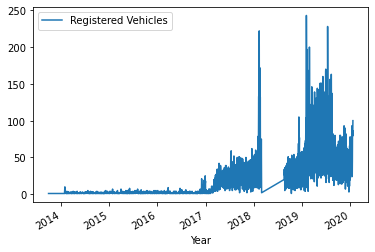

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

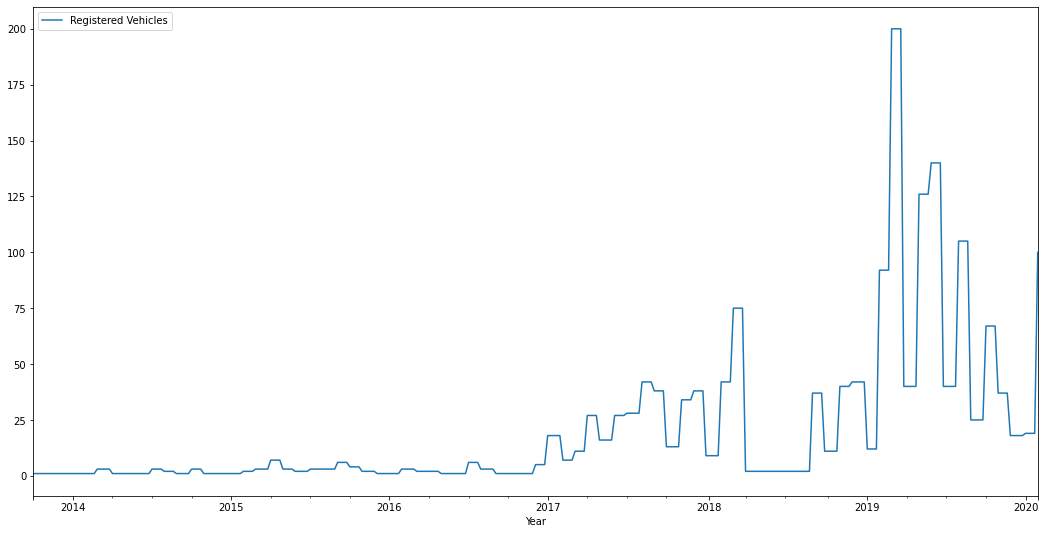

In [14]:
# #Frontfill 
df = df.resample('W').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(3.7949567364917596,
 1.0,
 11,
 65,
 {'1%': -3.5352168748293127,
  '5%': -2.9071540828402367,
  '10%': -2.5911025443786984},
 586.9952031640229)

## Modeling

In [24]:
# Splitting Training and Testing data; using after 2019 as test

train = df[:'2019-05']
test = df['2019-06':]
combined = df
test

,Registered Vehicles
Year,
2019-06-02,140.0
2019-06-09,140.0
2019-06-16,140.0
2019-06-23,140.0
2019-06-30,40.0
2019-07-07,40.0
2019-07-14,40.0
2019-07-21,40.0
2019-07-28,40.0


In [26]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2932.324, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2427.772, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2665.702, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2429.083, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2429.151, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2420.084, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2432.166, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2421.871, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2430.231, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2430.279, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2417.491, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2426.589, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2426.440, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : 

### The best model is :  ARIMA (2, 0, 1) (0,0,0) [0]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8075      0.023     78.878      0.000       1.763       1.852
ar.L2         -0.8034      0.024    -33.638      0.000      -0.850      -0.757
ma.L1         -1.0000     16.351     -0.061      0.951     -33.048      31.048
sigma2       203.1006   3320.215      0.061      0.951   -6304.401    6710.602


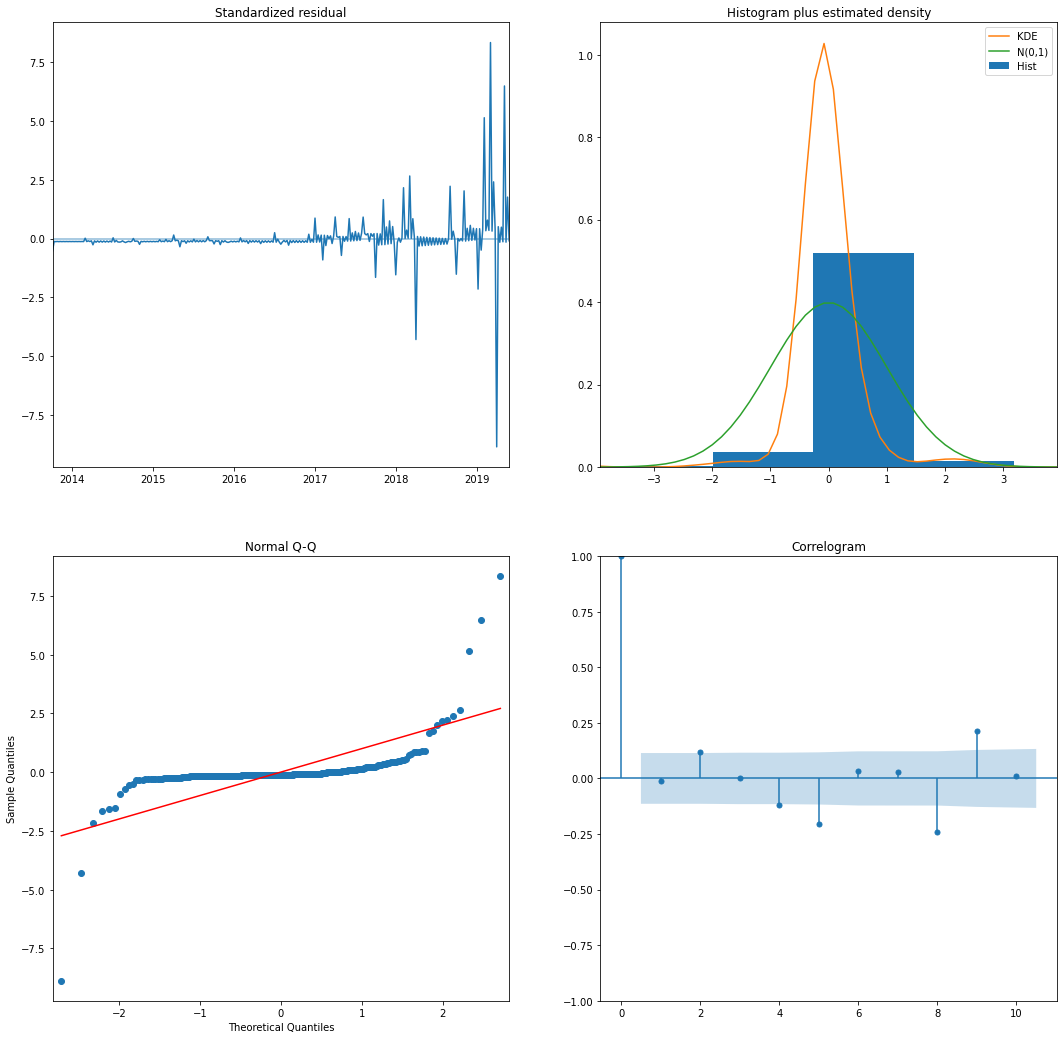

In [27]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [28]:
pred = output.get_prediction(start=pd.to_datetime('2019-06-02'), end=pd.to_datetime('2020-02-02'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2019-06-02,92.048906,148.008220
2019-06-09,79.693648,151.737600
2019-06-16,72.210691,153.224832
2019-06-23,67.478876,154.049868
2019-06-30,64.534070,154.750450
2019-07-07,62.827571,155.539416
2019-07-14,62.013201,156.498458
2019-07-21,61.859428,157.650900
2019-07-28,62.205455,158.993705
2019-08-04,62.936600,160.512715


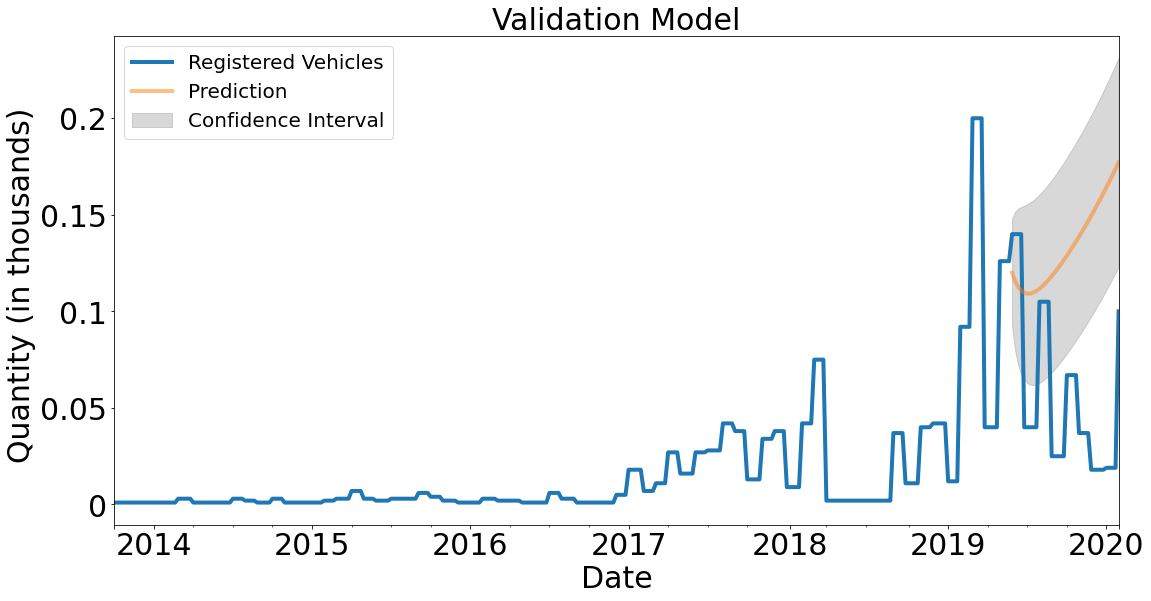

In [29]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()